In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
import joblib
import json
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load and prepare the data (same preprocessing)
path = "/content/drive/MyDrive/final_satelite_data.csv"
df = pd.read_csv(path)

path1 = "/content/drive/MyDrive/Copy of openaq_predicted_2023_2025.csv"
df1 = pd.read_csv(path1)

In [5]:
df['time'] = df1['time']
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.set_index('time', drop=True)
df = df.sort_index(ascending=True)

In [6]:
# Get last 12 months of data
df1 = df.last('12M')

In [7]:
# Sort by station and time
df1 = df1.sort_values(by=['latitude', 'longitude', df1.index.name], ascending=True)

In [8]:
# Drop unnecessary columns
drop_cols = ["Unnamed: 0", "aqi_pm25", "AQI", "AQI_Category_Encoded"]
df_clean = df1.drop(columns=[c for c in drop_cols if c in df1.columns])

In [9]:
# Feature engineering
for pollutant in ["pm25", "pm10", "no2", "so2", "co", "o3"]:
    df_clean[f"{pollutant}_lag1"] = df_clean[pollutant].shift(1)
    df_clean[f"{pollutant}_lag3"] = df_clean[pollutant].shift(3)
    df_clean[f"{pollutant}_lag6"] = df_clean[pollutant].shift(6)

for pollutant in ["pm25", "pm10", "no2", "so2", "co", "o3"]:
    df_clean[f"{pollutant}_mean_24h"] = (
        df_clean[pollutant].rolling(window=24, min_periods=1).mean()
    )

df_clean["pm25_pm10_ratio"] = df_clean["pm25"] / (df_clean["pm10"] + 1e-6)
df_clean["o3_no2_ratio"] = df_clean["o3"] / (df_clean["no2"] + 1e-6)


In [10]:
# Drop rows with NaN values created by lag features
df_clean = df_clean.dropna()
print("Data shape after preprocessing:", df_clean.shape)


Data shape after preprocessing: (1372394, 61)


In [11]:
# Define target pollutants for forecasting
target_pollutants = ['no2', 'so2', 'o3', 'co']
feature_columns = [col for col in df_clean.columns if col not in target_pollutants + ['pm25', 'pm10']]

print(f"Target pollutants: {target_pollutants}")
print(f"Number of features: {len(feature_columns)}")


Target pollutants: ['no2', 'so2', 'o3', 'co']
Number of features: 55


In [12]:

# evaluation function with classification metrics
def evaluate_model(y_true, y_pred, pollutant_name):
    """Comprehensive model evaluation with regression and classification metrics"""

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    try:
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    except:
        mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100

    explained_variance = 1 - (np.var(y_true - y_pred) / np.var(y_true))
    mean_bias = np.mean(y_pred - y_true)
    max_error = np.max(np.abs(y_true - y_pred))
    median_ae = np.median(np.abs(y_true - y_pred))

    # Classification metrics based on pollution thresholds
    # Convert to binary classification: High vs Low pollution
    threshold = np.median(y_true)  # Median as threshold
    y_true_binary = (y_true > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)

    # Classification metrics
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary, average='weighted', zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, average='weighted', zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, average='weighted', zero_division=0)

    return {
        # Regression metrics
        'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE (%)': mape,
        'Explained Variance': explained_variance, 'Mean Bias': mean_bias,
        'Max Error': max_error, 'Median AE': median_ae,

        # Classification metrics
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1,
        'Threshold': threshold
    }

In [53]:
models = {}
performance_metrics = {}
predictions = {}
classification_reports = {}

for pollutant in target_pollutants:
    print(f"\nTRAINING MODEL FOR {pollutant.upper()}")

    X = df_clean[feature_columns]
    y = df_clean[pollutant]

    split_date = df_clean.index.max() - timedelta(days=30)
    X_train = X[X.index <= split_date]
    X_test = X[X.index > split_date]
    y_train = y[y.index <= split_date]
    y_test = y[y.index > split_date]

    model = xgb.XGBRegressor(
        n_estimators=200, max_depth=8, learning_rate=0.05, random_state=42,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = model.predict(X_test)
    metrics = evaluate_model(y_test, y_pred, pollutant)

    models[pollutant] = model
    performance_metrics[pollutant] = metrics
    predictions[pollutant] = {'y_test': y_test, 'y_pred': y_pred, 'X_test': X_test}

    y_true_binary = (y_test > metrics['Threshold']).astype(int)
    y_pred_binary = (y_pred > metrics['Threshold']).astype(int)
    classification_reports[pollutant] = classification_report(y_true_binary, y_pred_binary, zero_division=0)

    print(f"{pollutant.upper()} R²: {metrics['R²']:.4f}, F1: {metrics['F1-Score']:.4f}")



TRAINING MODEL FOR NO2
NO2 R²: 0.9997, F1: 0.9985

TRAINING MODEL FOR SO2
SO2 R²: 0.9984, F1: 0.6923

TRAINING MODEL FOR O3
O3 R²: 0.9998, F1: 0.9976

TRAINING MODEL FOR CO
CO R²: 0.9989, F1: 0.9919


In [55]:
def enhanced_7_day_forecast(models, df_clean, feature_columns, target_pollutants, station_coords=None):
    """Enhanced forecasting with temporal feature updating"""

    print("ENHANCED 7-DAY FORECASTING")

    # Select recent station data
    if station_coords:
        lat, lon = station_coords
        recent_data = df_clean[(df_clean['latitude'] == lat) & (df_clean['longitude'] == lon)].iloc[-168:]
        print(f"Forecasting for Lat {lat:.4f}, Lon {lon:.4f}")
    else:
        station_counts = df_clean.groupby(['latitude', 'longitude']).size()
        rep_lat, rep_lon = station_counts.idxmax()
        recent_data = df_clean[(df_clean['latitude'] == rep_lat) & (df_clean['longitude'] == rep_lon)].iloc[-168:]
        print(f"Forecasting for representative station: Lat {rep_lat:.4f}, Lon {rep_lon:.4f}")

    if len(recent_data) == 0:
        print("No data available")
        return None

    forecasts, forecast_dates = {}, []
    last_date = recent_data.index.max()
    future_dates = [last_date + timedelta(days=i) for i in range(1, 8)]
    forecast_data = recent_data.copy()

    for day_idx, forecast_date in enumerate(future_dates):
        print(f"\nForecasting Day {day_idx+1} ({forecast_date.date()}):")
        current_features = forecast_data[feature_columns].iloc[-1:].copy()

        day_forecast = {}
        for pollutant in target_pollutants:
            prediction = models[pollutant].predict(current_features)[0]
            day_forecast[pollutant] = prediction
            print(f"  {pollutant.upper()}: {prediction:.6f}")

        for pollutant, value in day_forecast.items():
            forecasts.setdefault(pollutant, []).append(value)
        forecast_dates.append(forecast_date)

        new_row = forecast_data.iloc[-1:].copy()
        new_row.index = [forecast_date]
        for pollutant in target_pollutants:
            new_row[pollutant] = day_forecast[pollutant]

        for feature in ['temperature_celsius', 'wind_speed_10m', 'relative_humidity_2m']:
            if feature in new_row.columns:
                variation = np.random.normal(0, abs(new_row[feature].iloc[0]) * 0.05)
                new_row[feature] = new_row[feature].iloc[0] + variation

        new_row['hour_sin'] = np.sin(2 * np.pi * forecast_date.hour / 24)
        new_row['hour_cos'] = np.cos(2 * np.pi * forecast_date.hour / 24)
        new_row['dow_sin'] = np.sin(2 * np.pi * forecast_date.dayofweek / 7)
        new_row['dow_cos'] = np.cos(2 * np.pi * forecast_date.dayofweek / 7)
        new_row['month_sin'] = np.sin(2 * np.pi * forecast_date.month / 12)
        new_row['month_cos'] = np.cos(2 * np.pi * forecast_date.month / 12)

        for pollutant in target_pollutants:
            lag_col = f"{pollutant}_lag1"
            if lag_col in new_row.columns:
                new_row[lag_col] = day_forecast[pollutant]

        forecast_data = pd.concat([forecast_data, new_row])

    forecast_df = pd.DataFrame(index=forecast_dates)
    for pollutant in target_pollutants:
        forecast_df[pollutant] = forecasts[pollutant]
        forecast_df[f"{pollutant}_forecast"] = forecasts[pollutant]

    return forecast_df


In [56]:
enhanced_forecasts = enhanced_7_day_forecast(models, df_clean, feature_columns, target_pollutants)

if enhanced_forecasts is not None:
    print("\nFINAL 7-DAY FORECAST RESULTS")
    print(enhanced_forecasts.round(4))

    print("\nFORECAST TREND ANALYSIS")
    for pollutant in target_pollutants:
        values = enhanced_forecasts[pollutant]
        trend = "Increasing" if values.iloc[-1] > values.iloc[0] else "Decreasing" if values.iloc[-1] < values.iloc[0] else "Stable"
        volatility = values.std()
        change_pct = ((values.iloc[-1] - values.iloc[0]) / (abs(values.iloc[0]) + 1e-8)) * 100
        print(f"{pollutant.upper()} → Trend: {trend}, Volatility: {volatility:.4f}, Change: {change_pct:.2f}%")


ENHANCED 7-DAY FORECASTING
Forecasting for representative station: Lat 0.2611, Lon -1.3972

Forecasting Day 1 (2025-10-01):
  NO2: -0.166857
  SO2: 1.250528
  O3: -0.846225
  CO: 5.369698

Forecasting Day 2 (2025-10-02):
  NO2: -0.153457
  SO2: 1.251402
  O3: -0.843847
  CO: 3.808802

Forecasting Day 3 (2025-10-03):
  NO2: -0.153482
  SO2: 1.247615
  O3: -0.843847
  CO: 3.803235

Forecasting Day 4 (2025-10-04):
  NO2: -0.152169
  SO2: 1.219078
  O3: -0.844302
  CO: 3.996922

Forecasting Day 5 (2025-10-05):
  NO2: -0.172356
  SO2: 1.213567
  O3: -0.844255
  CO: 4.005302

Forecasting Day 6 (2025-10-06):
  NO2: -0.172356
  SO2: 1.213567
  O3: -0.844255
  CO: 4.005302

Forecasting Day 7 (2025-10-07):
  NO2: -0.151498
  SO2: 1.222339
  O3: -0.844162
  CO: 3.979341

FINAL 7-DAY FORECAST RESULTS
                              no2  no2_forecast     so2  so2_forecast      o3  \
2025-10-01 00:00:00+00:00 -0.1669       -0.1669  1.2505        1.2505 -0.8462   
2025-10-02 00:00:00+00:00 -0.1535     

In [57]:
print("\nSAVING MODELS AND METADATA")

for pollutant, model in models.items():
    model_filename = f'/content/drive/MyDrive/{pollutant}_xgboost_model.pkl'
    joblib.dump(model, model_filename)
    print(f"Saved {pollutant.upper()} model")

model_metadata = {
    'feature_columns': feature_columns,
    'target_pollutants': target_pollutants,
    'training_date': str(pd.Timestamp.now()),
    'data_shape': df_clean.shape,
    'performance_metrics': performance_metrics
}

with open('/content/drive/MyDrive/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print(" Saved model metadata")



SAVING MODELS AND METADATA
Saved NO2 model
Saved SO2 model
Saved O3 model
Saved CO model
 Saved model metadata


In [58]:
def predict_pollution(new_data, model_paths, feature_columns, target_pollutants):
    """Make predictions using saved models"""
    loaded_models = {}
    for pollutant in target_pollutants:
        model_path = f'/content/drive/MyDrive/{pollutant}_xgboost_model.pkl'
        loaded_models[pollutant] = joblib.load(model_path)

    missing_features = set(feature_columns) - set(new_data.columns)
    for feature in missing_features:
        new_data[feature] = 0
    new_data = new_data[feature_columns]

    predictions = {}
    for pollutant, model in loaded_models.items():
        pred = model.predict(new_data)
        predictions[pollutant] = pred
        print(f"{pollutant.upper()} prediction: {pred[0]:.6f}")
    return predictions

# Example usage
sample_data = df_clean[feature_columns].iloc[-1:].copy()
example_predictions = predict_pollution(sample_data, models, feature_columns, target_pollutants)


NO2 prediction: 0.998935
SO2 prediction: 1.094590
O3 prediction: -0.240004
CO prediction: -0.439184


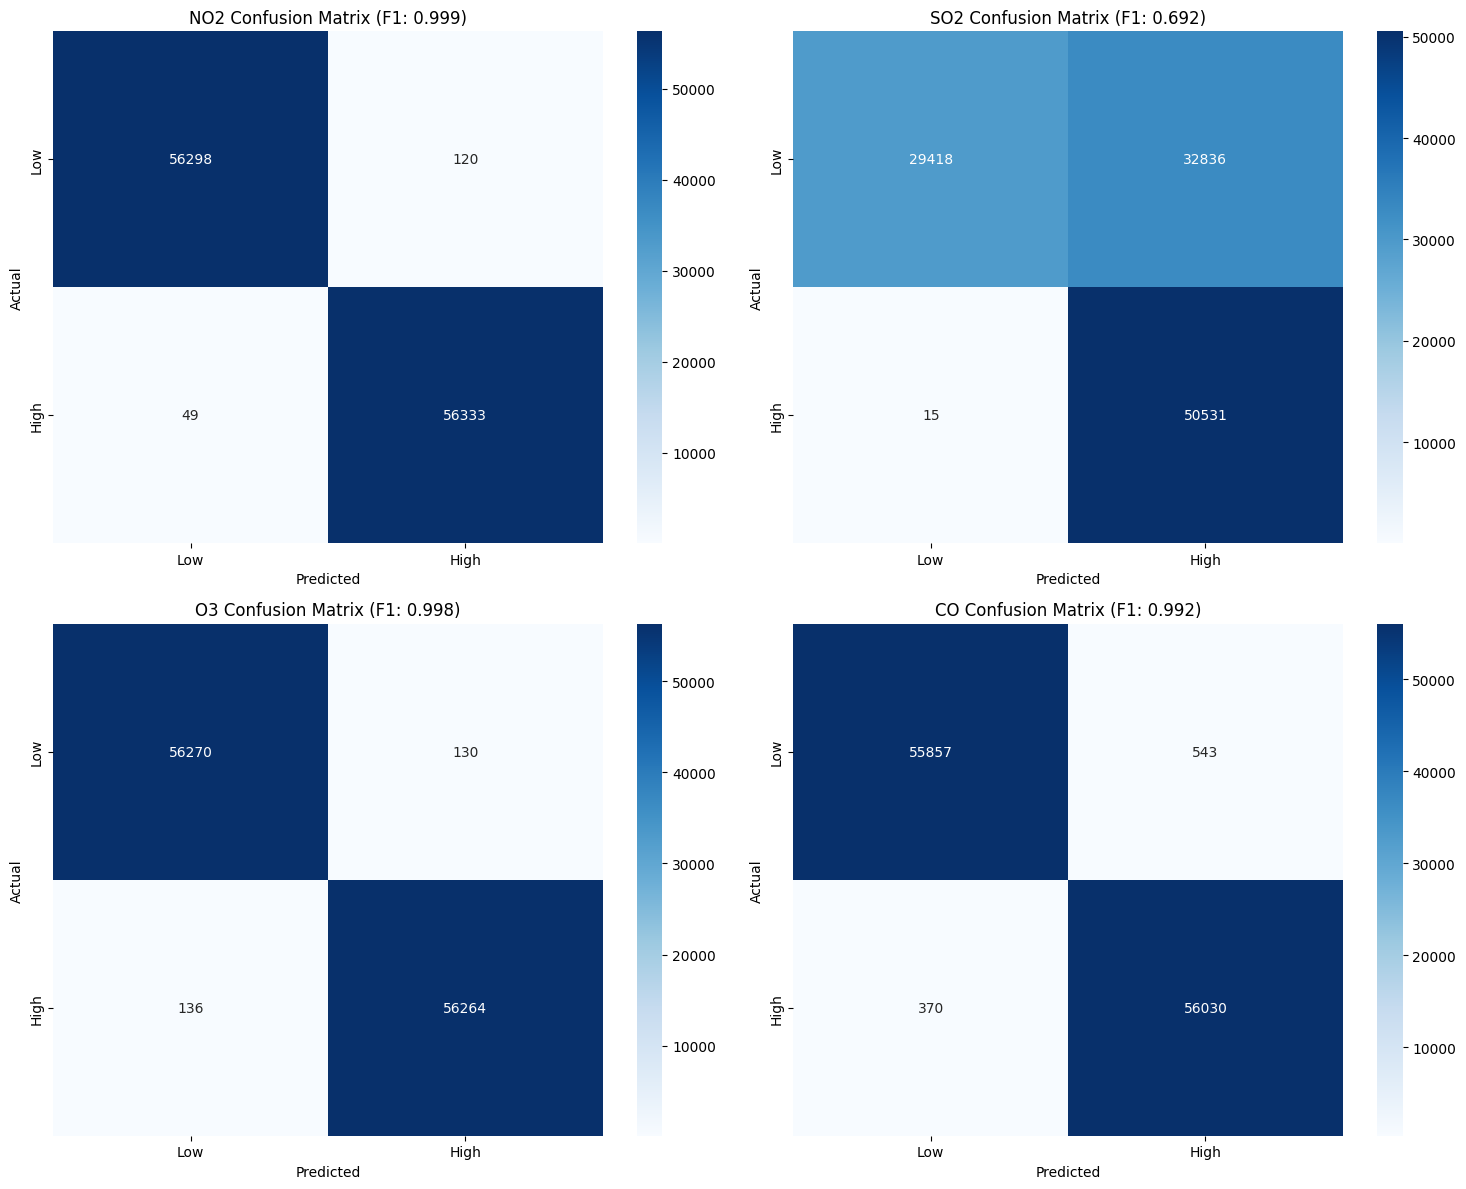

In [59]:
def plot_confusion_matrices(predictions, performance_metrics, target_pollutants):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, pollutant in enumerate(target_pollutants):
        if i < len(axes):
            ax = axes[i]
            y_test = predictions[pollutant]['y_test']
            y_pred = predictions[pollutant]['y_pred']

            threshold = performance_metrics[pollutant]['Threshold']
            y_true_binary = (y_test > threshold).astype(int)
            y_pred_binary = (y_pred > threshold).astype(int)

            cm = confusion_matrix(y_true_binary, y_pred_binary)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                        xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title(f"{pollutant.upper()} Confusion Matrix (F1: {performance_metrics[pollutant]['F1-Score']:.3f})")

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(predictions, performance_metrics, target_pollutants)


In [60]:
def save_comprehensive_results(performance_metrics, enhanced_forecasts, predictions, classification_reports):
    pd.DataFrame(performance_metrics).T.to_csv('/content/drive/MyDrive/pollutant_model_performance_comprehensive.csv')

    with open('/content/drive/MyDrive/classification_reports.txt', 'w') as f:
        for pollutant, report in classification_reports.items():
            f.write(f"{pollutant.upper()} Classification Report:\n{report}\n{'='*50}\n")

    if enhanced_forecasts is not None:
        enhanced_forecasts.to_csv('/content/drive/MyDrive/pollutant_forecasts_7days_comprehensive.csv')

    for pollutant in target_pollutants:
        pred_df = pd.DataFrame({
            'actual': predictions[pollutant]['y_test'],
            'predicted': predictions[pollutant]['y_pred'],
            'error': predictions[pollutant]['y_test'] - predictions[pollutant]['y_pred']
        })
        pred_df.to_csv(f'/content/drive/MyDrive/{pollutant}_detailed_predictions.csv', index=False)

    summary = {
        'average_r2': np.mean([m['R²'] for m in performance_metrics.values()]),
        'average_mape': np.mean([m['MAPE (%)'] for m in performance_metrics.values()]),
        'average_f1': np.mean([m['F1-Score'] for m in performance_metrics.values()]),
        'average_accuracy': np.mean([m['Accuracy'] for m in performance_metrics.values()]),
        'best_model': max(performance_metrics, key=lambda x: performance_metrics[x]['R²']),
        'total_stations': len(df_clean[['latitude', 'longitude']].drop_duplicates()),
        'forecast_period': '7 days'
    }
    pd.DataFrame([summary]).to_csv('/content/drive/MyDrive/forecasting_summary_comprehensive.csv', index=False)
    print(" All results saved")

save_comprehensive_results(performance_metrics, enhanced_forecasts, predictions, classification_reports)


 All results saved


In [61]:
print("\nFINAL PERFORMANCE SUMMARY")

avg_r2 = np.mean([m['R²'] for m in performance_metrics.values()])
avg_mape = np.mean([m['MAPE (%)'] for m in performance_metrics.values()])
avg_f1 = np.mean([m['F1-Score'] for m in performance_metrics.values()])
avg_accuracy = np.mean([m['Accuracy'] for m in performance_metrics.values()])

print(f"Overall Average R²: {avg_r2:.4f}")
print(f"Overall Average MAPE: {avg_mape:.2f}%")
print(f"Overall Average F1-Score: {avg_f1:.4f}")
print(f"Overall Average Accuracy: {avg_accuracy:.4f}")

summary_data = []
for pollutant in target_pollutants:
    metrics = performance_metrics[pollutant]
    summary_data.append({
        'Pollutant': pollutant.upper(),
        'R²': f"{metrics['R²']:.4f}",
        'MAPE': f"{metrics['MAPE (%)']:.2f}%",
        'F1-Score': f"{metrics['F1-Score']:.4f}",
        'Accuracy': f"{metrics['Accuracy']:.4f}",
        'Precision': f"{metrics['Precision']:.4f}",
        'Recall': f"{metrics['Recall']:.4f}"
    })

print(pd.DataFrame(summary_data).to_string(index=False))
print("\nPipeline Complete")



FINAL PERFORMANCE SUMMARY
Overall Average R²: 0.9992
Overall Average MAPE: 6.21%
Overall Average F1-Score: 0.9201
Overall Average Accuracy: 0.9242
Pollutant     R²   MAPE F1-Score Accuracy Precision Recall
      NO2 0.9997  4.84%   0.9985   0.9985    0.9985 0.9985
      SO2 0.9984  1.18%   0.6923   0.7088    0.8232 0.7088
       O3 0.9998  3.83%   0.9976   0.9976    0.9976 0.9976
       CO 0.9989 15.01%   0.9919   0.9919    0.9919 0.9919

Pipeline Complete
